In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
%load_ext Cython
%run ../prop/propagators_1d.py

In [2]:
%%cython --compile-args=-fopenmp --compile-args=-O3 --link-args=-fopenmp --force 
'''
Cythonized exact propagation in 1D.  
'''
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, cos, sin
from libc.stdlib cimport malloc, free
cimport cython
cimport openmp
from cython.parallel import prange


@cython.boundscheck(False)
@cython.wraparound(False)
cdef double complex add_clean(double complex *arr, int N):
    cdef double complex out = 0+0j
    cdef int k
    for k in range(N):
        out+=arr[k]
        arr[k] = 0
    return out


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef exact_prop_cython(double[:] in_wave, double complex [:] out_wave,\
               double L_in, double L_out, double wavel, double z):
    
    cdef double pi = 3.14159265359
    cdef int N_in  = in_wave.shape[0]
    cdef int N_out = out_wave.shape[0]
    cdef cnp.ndarray[cnp.float64_t, ndim=1] in_domain  = np.linspace(-L_in/2,L_in/2,N_in)
    cdef cnp.ndarray[cnp.float64_t, ndim=1] out_domain = np.linspace(-L_out/2,L_out/2,N_out)
    cdef double step_in = L_in/N_in
    
    cdef double complex fac1 = 0.7071067811865476-0.7071067811865476j #np.sqrt(1/1j)
    cdef double complex fac  = (step_in/sqrt(wavel*z))*fac1
    cdef double x,x1,f
    cdef int i,j
    cdef double _temp1
    cdef double complex _temp2
    
    cdef double complex *sum_temp = <double complex*> malloc(N_in * sizeof(double complex))
    add_clean(sum_temp,N_in)
    
    for i in range(N_out):
        x1 = out_domain[i]
        with nogil:
            for j in prange(N_in, num_threads = 10):
                f =   in_wave[j]
                x = in_domain[j]
                _temp1 = (((-1*pi)/(wavel*z))*(x-x1)**2)
                _temp2 = cos(_temp1)+1j*sin(_temp1)
                sum_temp[j] = _temp2*f*fac
        out_wave[i] = add_clean(sum_temp,N_in)
    return

In file included from /home/sajid/packages/spack/opt/spack/linux-centos7-x86_64/gcc-4.8.5/miniconda3-4.5.4-cn4y5gakwtozuu6thdozzmdekeo36qdg/envs/intelpy3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1818:0,
                 from /home/sajid/packages/spack/opt/spack/linux-centos7-x86_64/gcc-4.8.5/miniconda3-4.5.4-cn4y5gakwtozuu6thdozzmdekeo36qdg/envs/intelpy3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /home/sajid/packages/spack/opt/spack/linux-centos7-x86_64/gcc-4.8.5/miniconda3-4.5.4-cn4y5gakwtozuu6thdozzmdekeo36qdg/envs/intelpy3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/sajid/.cache/ipython/cython/_cython_magic_62b1ebd2a495fa331604b2c47968577b.c:593:
/home/sajid/packages/spack/opt/spack/linux-centos7-x86_64/gcc-4.8.5/miniconda3-4.5.4-cn4y5gakwtozuu6thdozzmdekeo36qdg/envs/intelpy3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h

In [3]:
wavel = 0.5*10**(-6)
pi = np.pi
z = 100
N = 1000
L_in  = 5e-1

in_domain_exact  = np.linspace(-L_in/2,L_in/2,N)
in_wave = np.zeros(N)
in_wave[int(N/2)-int(N/8):int(N/2)+int(N/8)] = 1

sampling = in_domain_exact[1] - in_domain_exact[0]
critical = (wavel*z/L_in)
if sampling>critical:
    print('Use TF')
else :
    print('Use IR')
print('Fresnel Number :', (L_in**2)/(wavel*z))

Use TF
Fresnel Number : 5000.0


In [4]:
out_,L_ = propIR(in_wave,L_in/N,L_in,wavel,z)
out_domain_ = np.linspace(-L_/2,L_/2,N)

In [5]:
N = 5000
in_domain_exact  = np.linspace(-L_in/2,L_in/2,N)
in_wave = np.zeros(N)
in_wave[int(N/2)-int(N/8):int(N/2)+int(N/8)] = 1
out_wave_exact = np.zeros((N),dtype='complex128')
exact_prop_cython(in_wave,out_wave_exact,L_in,L_,wavel,z)

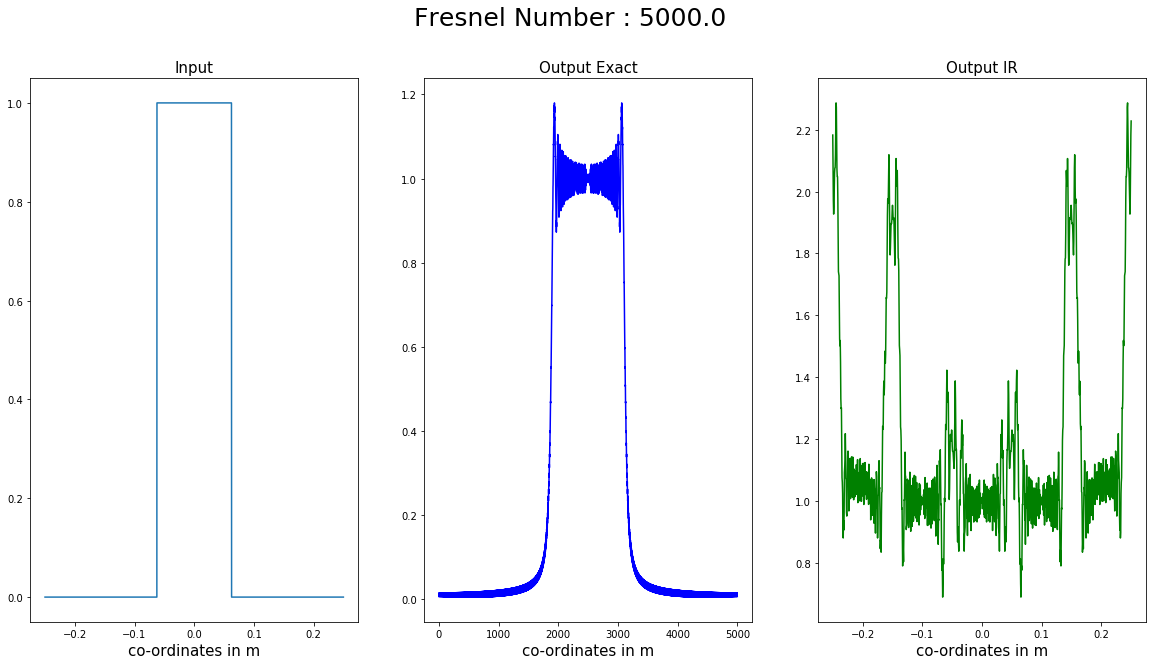

In [ ]:
f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.plot(in_domain_exact,np.abs(in_wave))
ax1.set_xlabel('co-ordinates in m',fontsize = 15)
ax1.set_title('Input', fontsize = 15)
ax2.plot(np.abs(out_wave_exact),'b')
ax2.set_xlabel('co-ordinates in m',fontsize = 15)
ax2.set_title('Output Exact', fontsize = 15)
ax3.plot( out_domain_,np.abs(out_),'g')
ax3.set_xlabel('co-ordinates in m',fontsize = 15)
ax3.set_title('Output IR', fontsize = 15)
f.set_size_inches(20, 10, forward=True)
f.suptitle('Fresnel Number : '+str((L_in**2)/(wavel*z)),fontsize = 25)
plt.show()

In [ ]:
%timeit exact_prop_cython(in_wave,out_wave_exact,L_in,L_,wavel,z)